In [ ]:
import json
import math
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Concatenate, Dense, AdditiveAttention

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy


In [ ]:

# batch_size = 16
batch_size = 64
IMG_HEIGHT = int(224)
IMG_WIDTH = int(224)

In [ ]:

# mount google drive
WORK_PATH = 'C:/Users/ADMIN/Contacts/KLTN/data'
SAVE_PATH = 'C:/Users/ADMIN/Contacts/KLTN/model'

In [ ]:
def build_model_vgg19():
    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
    model = keras.applications.VGG19(include_top= False, weights= 'imagenet', input_tensor= inputs)
    x = model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu', name='dense_6')(x)
    x = keras.layers.Dense(128, activation='relu', name='dense_7')(x)
    x = keras.layers.Dense(64, activation='relu', name='dense_8')(x)
    x = keras.layers.Dense(32, activation='relu', name='dense_9')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5,activation= 'softmax', name='dense_out')(x)
    model = keras.Model(inputs=inputs, outputs = outputs,name="model_use_VGG19_addDense256-128-64-32")
    l = len(model.layers)
    for i, layer in enumerate(model.layers):
        if i <= 0.5*l: layer.trainable = False
    model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
    return model

In [ ]:
def build_model_resnet50():
    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
    model = keras.applications.resnet50.ResNet50(include_top= False, weights= 'imagenet', input_tensor= inputs)
    x = model.output
    x = keras.layers.GlobalAvgPool2D()(x)

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5,activation= 'softmax')(x)
    model = keras.Model(inputs=inputs, outputs = outputs,name="model_use_ResNet50")
    # Đóng băng 1 phần mô hình
    l = len(model.layers)
    for i, layer in enumerate(model.layers):
        if i <= 0.7*l: layer.trainable = False
    return model

In [ ]:
def build_model_resnet101():
    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
    model = tf.keras.applications.ResNet101(include_top= False, weights= 'imagenet', input_tensor= inputs)
    x = model.output
    x = keras.layers.GlobalAvgPool2D()(x)
    x = keras.layers.Dropout(0.7)(x)
    outputs = keras.layers.Dense(5,activation= 'softmax')(x)
    model = keras.Model(inputs=inputs, outputs = outputs,name="model_use_ResNet101")
    # Đóng băng 1 phần mô hình
    l = len(model.layers)
    for i, layer in enumerate(model.layers):
        if i <= 0.8*l: layer.trainable = False
    return model


In [ ]:
def model_connect():
    model1 = build_model_resnet50()
    model1.load_weights(os.path.join(SAVE_PATH,'Model_Resnet50_final.h5'))
    model1.compile(optimizer= keras.optimizers.Adam(learning_rate=0.00001,
                                                  amsgrad=True),
                loss='categorical_crossentropy',metrics='accuracy')
    model1.trainable =  False

    model2 = build_model_resnet101()
    model2.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_final1.h5'))
    model2.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                    amsgrad=True),
                  loss='categorical_crossentropy',metrics='accuracy')
    model2.trainable =  False

    model3 = build_model_vgg19()
    model3.load_weights(os.path.join(SAVE_PATH,'Model_VGG19_final1.h5'))
    model3.trainable =  False


    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')

    output1 = model1(inputs)
    output2 = model2(inputs)
    output3 = model3(inputs)

    concatenated = Concatenate()([output1, output2, output3])
    combined_output = Dense(5, activation='softmax')(concatenated)

    combined_model = Model(inputs, combined_output)
    combined_model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
    return combined_model


In [ ]:
test_model = model_connect()
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_use_ResNet50 (Functional  (None, 5)           23597957    ['inputs[0][0]']                 
 )                                                                                                
                                                                                                  
 model_use_ResNet101 (Functiona  (None, 5)           42668421    ['inputs[0][0]']                 
 l)                                                                                           

In [ ]:
No_DR = 17295
Mild =3581
Moderate = 1641
Severe = 605
Proliferative_DR = 470
total=No_DR + Mild + Proliferative_DR + Severe + Moderate

weight_for_0 = (1 / Mild) * (total / 5.0)
weight_for_1 = (1 / Moderate) * (total / 5.0)
weight_for_2 = (1 / No_DR) * (total / 5.0)
weight_for_3 = (1 / Proliferative_DR) * (total / 5.0)
weight_for_4 = (1 / Severe) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}
class_weight

{0: 1.3176207763194636,
 1: 2.8753199268738574,
 2: 0.2728187337380746,
 3: 10.039148936170212,
 4: 7.799008264462809}

In [ ]:
train_image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255) # Generator for our training data

i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'Train_all'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

test_image_generator = ImageDataGenerator(rescale=1./255)
i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 28086 images belonging to 5 classes.
Found 7023 images belonging to 5 classes.


In [ ]:
model1 = build_model_resnet50()
model1.load_weights(os.path.join(SAVE_PATH,'Model_Resnet50_final.h5'))
model1.compile(optimizer= keras.optimizers.Adam(learning_rate=0.00001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')
model1.trainable =  False

model2 = build_model_resnet101()
model2.load_weights(os.path.join(SAVE_PATH,'Model_Resnet101_final1.h5'))
model2.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')
model2.trainable =  False

model3 = build_model_vgg19()
model3.load_weights(os.path.join(SAVE_PATH,'Model_VGG19_final1.h5'))
model3.trainable =  False
# Đánh giá trên tập train và tập test
print("train1:")
model1.evaluate(i_train)
print("test1:")
model1.evaluate(i_test)

print("train2:")
model2.evaluate(i_train)
print("test2:")
model2.evaluate(i_test)

print("train3:")
model3.evaluate(i_train)
print("test3:")
model3.evaluate(i_test)

train1:
439/439 [==============================] - 503s 1s/step - loss: 0.1158 - accuracy: 0.9584
test1:
110/110 [==============================] - 120s 1s/step - loss: 0.5909 - accuracy: 0.8108
train2:
439/439 [==============================] - 98s 217ms/step - loss: 0.0284 - accuracy: 0.9920
test2:
110/110 [==============================] - 24s 215ms/step - loss: 1.1817 - accuracy: 0.7485
train3:
439/439 [==============================] - 111s 238ms/step - loss: 0.1100 - accuracy: 0.9594
test3:
110/110 [==============================] - 33s 296ms/step - loss: 0.8354 - accuracy: 0.8115


[0.835364818572998, 0.8114765882492065]

In [ ]:
combined_model = model_connect()
combined_model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                                amsgrad=True),
              loss='categorical_crossentropy',metrics='accuracy')

https://www.educative.io/answers/how-to-merge-two-different-models-in-keras

https://stackoverflow.com/questions/73451047/how-to-merge-2-trained-model-in-keras

In [ ]:
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_all_end.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]



In [ ]:
history = combined_model.fit(i_train,validation_data = i_test ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
439/439 [==============================] - 289s 642ms/step - loss: 1.7398 - accuracy: 0.7093 - val_loss: 1.2925 - val_accuracy: 0.6501
Epoch 2/100
439/439 [==============================] - 276s 628ms/step - loss: 1.5423 - accuracy: 0.7655 - val_loss: 1.1833 - val_accuracy: 0.7117
Epoch 3/100
439/439 [==============================] - 277s 631ms/step - loss: 1.3621 - accuracy: 0.8805 - val_loss: 1.0869 - val_accuracy: 0.7424
Epoch 4/100
439/439 [==============================] - 277s 631ms/step - loss: 1.1988 - accuracy: 0.8951 - val_loss: 1.0019 - val_accuracy: 0.7642
Epoch 5/100
439/439 [==============================] - 278s 632ms/step - loss: 1.0537 - accuracy: 0.9576 - val_loss: 0.9285 - val_accuracy: 0.7823
Epoch 6/100
439/439 [==============================] - 277s 630ms/step - loss: 0.9279 - accuracy: 0.9735 - val_loss: 0.8662 - val_accuracy: 0.8025
Epoch 7/100
439/439 [==============================] - 277s 631ms/step - loss: 0.8176 - accuracy: 0.9969 - val_loss: 0

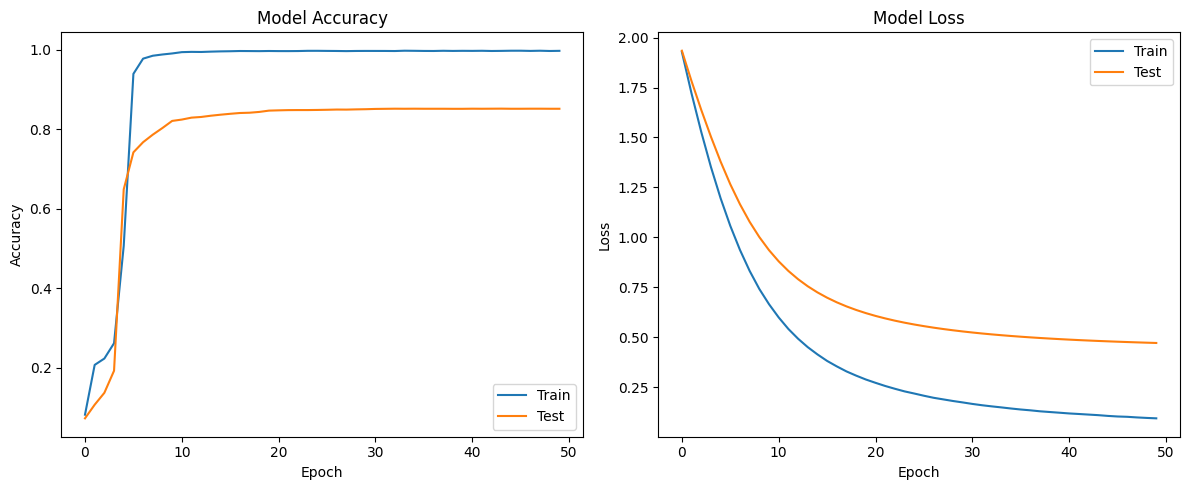

In [ ]:
# Lịch sử accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

# Lịch sử loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá trên tập train và tập test
print("train:")
combined_model.evaluate(i_train)
print("test:")
combined_model.evaluate(i_test)

train:
439/439 [==============================] - 217s 494ms/step - loss: 0.0954 - accuracy: 0.9978
test:
110/110 [==============================] - 54s 493ms/step - loss: 0.4720 - accuracy: 0.8521


[0.47202926874160767, 0.8520575165748596]

In [ ]:


# Lấy trọng số của lớp đầu ra của mô hình mới
combined_output_weights = combined_model.layers[-1].get_weights()

print("Weights of output layer from combined model:", combined_output_weights)



Weights of output layer from combined model: [array([[-0.33845627,  0.05087912, -0.02595907, -0.3440466 ,  0.12060386],
       [ 0.45326245, -0.05874637,  0.3269527 ,  0.09950018,  0.05852622],
       [-0.23997155, -0.32505095,  0.3556912 ,  0.16839641,  0.49037576],
       [ 0.03429824, -0.21573782,  0.09031403, -0.4508621 ,  0.0482406 ],
       [-0.31730008,  0.5015595 , -0.19268996, -0.4434241 , -0.24408048],
       [ 0.35995525,  0.13771963,  0.04878259, -0.23902035, -0.29799473],
       [ 0.48672485,  0.44290596, -0.40926105,  0.27089536, -0.2631543 ],
       [ 0.20545423,  0.30503273,  0.27946168, -0.16883639, -0.24553588],
       [-0.13737282, -0.45373726, -0.01154679, -0.18467218,  0.10287064],
       [-0.49638483,  0.4777522 , -0.08132699, -0.48487017,  0.44915104],
       [-0.14273015,  0.40232623, -0.5462669 ,  0.38646168, -0.1804235 ],
       [-0.01794046, -0.00851262,  0.3379423 ,  0.04471791, -0.03474689],
       [ 0.5114795 , -0.2820392 ,  0.13195723,  0.33422565,  0.012

In [ ]:
test = np.array([[.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2,.2]])
array =np.array([[-0.33845627,  0.05087912, -0.02595907, -0.3440466 ,  0.12060386],
[ 0.45326245, -0.05874637,  0.3269527 ,  0.09950018,  0.05852622],
[-0.23997155, -0.32505095,  0.3556912 ,  0.16839641,  0.49037576],
[ 0.03429824, -0.21573782,  0.09031403, -0.4508621 ,  0.0482406 ],
[-0.31730008,  0.5015595 , -0.19268996, -0.4434241 , -0.24408048],
[ 0.35995525,  0.13771963,  0.04878259, -0.23902035, -0.29799473],
[ 0.48672485,  0.44290596, -0.40926105,  0.27089536, -0.2631543 ],
[ 0.20545423,  0.30503273,  0.27946168, -0.16883639, -0.24553588],
[-0.13737282, -0.45373726, -0.01154679, -0.18467218,  0.10287064],
[-0.49638483,  0.4777522 , -0.08132699, -0.48487017,  0.44915104],
[-0.14273015,  0.40232623, -0.5462669 ,  0.38646168, -0.1804235 ],
[-0.01794046, -0.00851262,  0.3379423 ,  0.04471791, -0.03474689],
[ 0.5114795 , -0.2820392 ,  0.13195723,  0.33422565,  0.01259083],
[-0.23245966, -0.04595393, -0.20627901, -0.12142849, -0.15454909],
[-0.07535836,  0.46549582,  0.38793123, -0.20317769,  0.21451569]])
test@array, np.sum(test@array)

(array([[ 0.01064007,  0.27877861,  0.09714064, -0.26722818,  0.01527795]]),
 0.1346090920000001)

In [ ]:
softmax_layer = keras.layers.Softmax()
input = test@array
result = softmax_layer(input)
result, np.sum(result)

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.19380125, 0.25340062, 0.21131158, 0.1467844 , 0.19470216]],
       dtype=float32)>,
 1.0)

In [ ]:
inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
output1 = model1(inputs)
output2 = model2(inputs)
output3 = model3(inputs)

In [ ]:
def load_images(file_paths):
    if file_paths:
        images = []
        for file_path in file_paths:
            img = keras.utils.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = keras.utils.img_to_array(img)
            img = img / 255.0
            images.append(img)
        return np.array(images)
def predict_images(model, file_paths):
    images = load_images(file_paths)
    # predictions = np.argmax(model.predict(images), axis = 1)
    # return np.array([labels[i] for i in predictions])
    return model.predict(images)
y_pred = predict_images(model1,[os.path.join(WORK_PATH,"test/Severe/11590_right.jpeg"),os.path.join(WORK_PATH,"test/Moderate/10250_right.jpeg")])
print(y_pred)
y_pred = predict_images(model2,[os.path.join(WORK_PATH,"test/Severe/11590_right.jpeg"),os.path.join(WORK_PATH,"test/Moderate/10250_right.jpeg")])
print(y_pred)
y_pred = predict_images(model3,[os.path.join(WORK_PATH,"test/Severe/11590_right.jpeg"),os.path.join(WORK_PATH,"test/Moderate/10250_right.jpeg")])
print(y_pred)

1/1 [==============================] - 8s 8s/step
[[6.13248922e-05 2.04500984e-02 9.98304598e-03 1.12262433e-02
  9.58279252e-01]
 [1.51198965e-05 9.54106271e-01 4.58770245e-02 5.86425301e-07
  1.03909531e-06]]
1/1 [==============================] - 2s 2s/step
[[6.7110459e-06 1.7998524e-02 9.7990179e-01 2.6634000e-06 2.0902844e-03]
 [4.4055283e-03 8.9341104e-03 9.8507279e-01 3.0397679e-05 1.5570656e-03]]
1/1 [==============================] - 1s 631ms/step
[[4.4368606e-15 1.0217036e-06 2.7233776e-13 1.4290214e-07 9.9999881e-01]
 [3.2985864e-12 9.9999964e-01 3.5906032e-07 7.0049781e-14 4.4965261e-11]]


In [ ]:
sum([6.13248922e-05, 2.04500984e-02, 9.98304598e-03, 1.12262433e-02, 9.58279252e-01])

0.9999999645722

In [ ]:
model_end = model_connect()
model_end.load_weights(os.path.join(SAVE_PATH,'Model_all_end.h5'))


In [ ]:
# Đánh giá trên tập train và tập test
print("train:")
model_end.evaluate(i_train)
print("test:")
model_end.evaluate(i_test)

train:
439/439 [==============================] - 236s 507ms/step - loss: 0.1093 - accuracy: 0.9979
test:
110/110 [==============================] - 60s 546ms/step - loss: 0.4822 - accuracy: 0.8523


[0.4821631908416748, 0.8523423075675964]

In [ ]:
def load_images(file_paths):
    if file_paths:
        images = []
        for file_path in file_paths:
            img = keras.utils.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = keras.utils.img_to_array(img)
            img = img / 255.0
            images.append(img)
        return np.array(images)
def predict_images(model, file_paths):
    images = load_images(file_paths)
    # predictions = np.argmax(model.predict(images), axis = 1)
    # return np.array([labels[i] for i in predictions])
    return model.predict(images)
y_pred = predict_images(model_end,[os.path.join(WORK_PATH,"test/Severe/11590_right.jpeg"),os.path.join(WORK_PATH,"test/Moderate/10250_right.jpeg")])
np.argmax(y_pred, axis=1)

1/1 [==============================] - 3s 3s/step


array([4, 1], dtype=int64)